<a href="https://colab.research.google.com/github/Isaacfer49/Danone-Hackathon-Data-Science-challenge/blob/main/danone_models_and_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Danone's hackathon Isaac Fernandez

I will focus on extracting value from a crucial feature called "packaging materials," which provides information about whether the materials are plastic or not. Additionally, I made efforts to extract valuable data from other variables.

This notebook documents the majority of the steps I took to achieve the highest possible f1-score. I experimented with various models and different hyperparameters. The highest f1-score I obtained here was 86%; however, this score did not perform as anticipated on the testing set. Consequently, I had to revert to using other features that I had previously employed.

Please disregard the abundance of models and JSON files included in this notebook. They were solely for the purpose of testing additional f1-scores.

Thank you.

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import mean_squared_error
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
data_train = pd.read_json('/content/train_products.json')

In [ ]:
data_train = data_train.T

In [ ]:
data_train.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade'],
      dtype='object')

In [ ]:
numerical_v1 = data_train[['non_recyclable_and_non_biodegradable_materials_count','est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution','est_co2_packaging', 'est_co2_processing', 'est_co2_transportation','ecoscore_grade']]

In [ ]:
numerical_v1

,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4
...,...,...,...,...,...,...,...,...
20830,1,0.124785,0,0.015377,0.100104,0.116079,0.14558,1
20831,1,19.495674,0,0.015709,0.100104,6.998544,0.456216,4
20832,1,1.463891,0,0.017321,0.104294,15.259235,0.265547,4
20833,1,7.304731,0.006688,0.039033,0.180553,0.05647,0.233556,3


In [ ]:
for column in numerical_v1.columns:
  numerical_v1[column] = numerical_v1[column].astype(float)
features = numerical_v1.iloc[:,:-1]
targets = numerical_v1.iloc[:,-1:]


<ipython-input-7-6abf317e604a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_v1[column] = numerical_v1[column].astype(float)


In [ ]:
mlb = MultiLabelBinarizer()

# Fit and transform the column with lists
encoded_data = mlb.fit_transform(data_train['packaging_materials'])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_)

In [ ]:
df_encoded = pd.concat([numerical_v1, encoded_df], axis=1)

# Remove the original 'categories' column if desired
df_encoded.drop('ecoscore_grade', axis=1, inplace=True)
df_encoded['ecoscore_grade'] = data_train['ecoscore_grade']


In [ ]:
features = df_encoded.iloc[:,:-1]
targets = df_encoded.iloc[:,-1:]
targets = targets.astype('int')

In [ ]:
features.columns

Index(['non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'de:PP - Polypropylen,05', 'en:22', 'en:40', 'en:90', 'en:baking-paper',
       'en:brown-glass', 'en:cardboard', 'en:clear-glass',
       'en:composite-material', 'en:cork', 'en:corrugated-cardboard',
       'en:elopak', 'en:fabric', 'en:fsc-cardboard', 'en:fsc-paper',
       'en:glass', 'en:green-glass', 'en:hdpe-2-high-density-polyethylene',
       'en:hdpe-high-density-polyethylene', 'en:heavy-aluminium',
       'en:italpack', 'en:kraft-paper', 'en:ldpe-4-low-density-polyethylene',
       'en:ldpe-low-density-polyethylene', 'en:light-aluminium', 'en:metal',
       'en:multilayer-composite', 'en:non-corrugated-cardboard',
       'en:o-7-other-plastics', 'en:opaque-pet', 'en:other-paper',
       'en:other-plastics', 'en:paper',
       'en:paper-and-cardboard-plasti

In [ ]:
columns = ['non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation','']

In [ ]:
test_features = pd.read_json('/content/test_products.json')
test_features = test_features.T
numerical_v2 = test_features[['non_recyclable_and_non_biodegradable_materials_count','est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution','est_co2_packaging', 'est_co2_processing', 'est_co2_transportation']]

In [ ]:
encoded_data = mlb.fit_transform(test_features['packaging_materials'])

# Create a DataFrame with the encoded features
encoded_df2 = pd.DataFrame(encoded_data, columns=mlb.classes_)
df_encoded2 = pd.concat([numerical_v2, encoded_df2], axis=1)

In [ ]:
df_encoded2.columns

Index(['non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'de:06 PS Polystyrol', 'en:cardboard', 'en:elopak', 'en:fsc-paper',
       'en:glass', 'en:hdpe-2-high-density-polyethylene',
       'en:hdpe-high-density-polyethylene', 'en:heavy-aluminium',
       'en:ldpe-low-density-polyethylene', 'en:light-aluminium', 'en:metal',
       'en:multilayer-composite', 'en:non-corrugated-cardboard', 'en:paper',
       'en:paper-and-plastic', 'en:paperboard',
       'en:pet-1-polyethylene-terephthalate',
       'en:pet-polyethylene-terephthalate', 'en:pla-polylactic-acid',
       'en:plastic', 'en:pp-polypropylene', 'en:ps-6-polystyrene',
       'en:ps-polystyrene', 'en:pure-pak', 'en:tetra-brik', 'en:tetra-pak',
       'en:tetra-top', 'en:unknown', 'fr:A14', 'fr:pet alu'],
      dtype='object')

In [ ]:
for column in df_encoded2.columns:
  df_encoded2[column] = df_encoded2[column].astype(float)

In [ ]:
columns = ['non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'de:06 PS Polystyrol', 'en:cardboard', 'en:elopak', 'en:fsc-paper',
       'en:glass', 'en:hdpe-2-high-density-polyethylene',
       'en:hdpe-high-density-polyethylene', 'en:heavy-aluminium',
       'en:ldpe-low-density-polyethylene', 'en:light-aluminium', 'en:metal',
       'en:multilayer-composite', 'en:non-corrugated-cardboard', 'en:paper',
       'en:paper-and-plastic', 'en:paperboard',
       'en:pet-1-polyethylene-terephthalate',
       'en:pet-polyethylene-terephthalate', 'en:pla-polylactic-acid',
       'en:plastic', 'en:pp-polypropylene', 'en:ps-6-polystyrene',
       'en:ps-polystyrene', 'en:pure-pak', 'en:tetra-brik', 'en:tetra-pak',
       'en:tetra-top', 'en:unknown', 'fr:A14', 'fr:pet alu']

In [ ]:
columns_to_remove = ['de:06 PS Polystyrol', 'en:pla-polylactic-acid', 'en:pure-pak', 'en:tetra-top', 'fr:A14', 'fr:pet alu']

In [ ]:
columns = [element for element in columns if element not in columns_to_remove]

In [ ]:
features = df_encoded[columns]

In [ ]:
data_train.replace('unknown', pd.NA, inplace=True)

In [ ]:
data_train.isna().sum()

name                                                      328
brand                                                       0
generic_name                                            18624
categories_hierarchy                                        0
is_beverage                                                 0
selling_countries                                           3
ingredient_origins                                          0
ingredients                                              5154
additives_count                                          5154
calcium_100g                                            19888
carbohydrates_100g                                       2277
energy_kcal_100g                                         4842
fat_100g                                                 2335
fiber_100g                                               7522
proteins_100g                                            2278
salt_100g                                                2575
sodium_1

In [ ]:
features['is_beverage'] = data_train['is_beverage']
features['additives_count'] = data_train['additives_count']
features['additives_count'].fillna(features['additives_count'].mode().iloc[0], inplace=True)

<ipython-input-51-21ab2b70670f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['is_beverage'] = data_train['is_beverage']
<ipython-input-51-21ab2b70670f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['additives_count'] = data_train['additives_count']
<ipython-input-51-21ab2b70670f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [ ]:
data_train['nutrition_grade'].isna().sum()
data_train['nutrition_grade'].fillna(data_train['nutrition_grade'].mode().iloc[0], inplace=True)

In [ ]:
label_encoder = LabelEncoder()

# Apply label encoding to the 'nutrition grade' column
data_train['nutrition_grade'] = label_encoder.fit_transform(data_train['nutrition_grade'])

In [ ]:
features['nutrition_grade'] = data_train['nutrition_grade']

<ipython-input-67-729497f36c40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['nutrition_grade'] = data_train['nutrition_grade']


In [ ]:
features.drop(['nutrition_grade'],axis=1)

,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,en:cardboard,en:elopak,en:fsc-paper,...,en:pet-polyethylene-terephthalate,en:plastic,en:pp-polypropylene,en:ps-6-polystyrene,en:ps-polystyrene,en:tetra-brik,en:tetra-pak,en:unknown,is_beverage,additives_count
0,1.0,1.405794,0.122097,0.151978,0.400866,0.123400,0.344651,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1.0,1.772009,0.000000,0.019531,0.288156,5.215055,0.171567,1,0,0,...,0,1,0,0,0,0,0,0,0,10
2,1.0,2.239600,0.000000,0.019531,0.281596,0.770511,0.252874,0,0,0,...,0,1,0,0,0,0,0,0,0,3
3,1.0,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,0,0,0,...,0,1,0,0,0,0,0,0,0,2
4,0.0,7.918371,0.000000,0.015709,0.478390,0.445327,0.334988,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,1.0,0.124785,0.000000,0.015377,0.100104,0.116079,0.145580,0,0,0,...,0,0,0,0,0,0,0,1,1,0
20831,1.0,19.495674,0.000000,0.015709,0.100104,6.998544,0.456216,0,0,0,...,0,0,0,0,0,0,0,1,1,0
20832,1.0,1.463891,0.000000,0.017321,0.104294,15.259235,0.265547,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20833,1.0,7.304731,0.006688,0.039033,0.180553,0.056470,0.233556,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
encoded_features = pd.get_dummies(data_train['nutrition_grade'])

In [ ]:
features1 = pd.concat([features, encoded_features], axis=1)

In [ ]:
features1.head(5)
features1.columns = features1.columns.astype(str)

In [ ]:
features1.drop('nutrition_grade',axis=1)

,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,en:cardboard,en:elopak,en:fsc-paper,...,en:tetra-brik,en:tetra-pak,en:unknown,is_beverage,additives_count,0,1,2,3,4
0,1.0,1.405794,0.122097,0.151978,0.400866,0.123400,0.344651,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1.0,1.772009,0.000000,0.019531,0.288156,5.215055,0.171567,1,0,0,...,0,0,0,0,10,0,0,0,0,1
2,1.0,2.239600,0.000000,0.019531,0.281596,0.770511,0.252874,0,0,0,...,0,0,0,0,3,0,0,0,1,0
3,1.0,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,0,0,0,...,0,0,0,0,2,0,0,0,0,1
4,0.0,7.918371,0.000000,0.015709,0.478390,0.445327,0.334988,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,1.0,0.124785,0.000000,0.015377,0.100104,0.116079,0.145580,0,0,0,...,0,0,1,1,0,0,0,0,1,0
20831,1.0,19.495674,0.000000,0.015709,0.100104,6.998544,0.456216,0,0,0,...,0,0,1,1,0,0,0,0,1,0
20832,1.0,1.463891,0.000000,0.017321,0.104294,15.259235,0.265547,0,0,0,...,0,0,1,0,0,0,0,0,1,0
20833,1.0,7.304731,0.006688,0.039033,0.180553,0.056470,0.233556,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<ipython-input-121-88cb85eacf28>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(train_features, train_targets)


              precision    recall  f1-score   support

           0       0.87      0.86      0.86       304
           1       0.91      0.92      0.91      1284
           2       0.78      0.73      0.75       714
           3       0.83      0.87      0.85      1218
           4       0.88      0.86      0.87       647

    accuracy                           0.86      4167
   macro avg       0.85      0.85      0.85      4167
weighted avg       0.86      0.86      0.86      4167



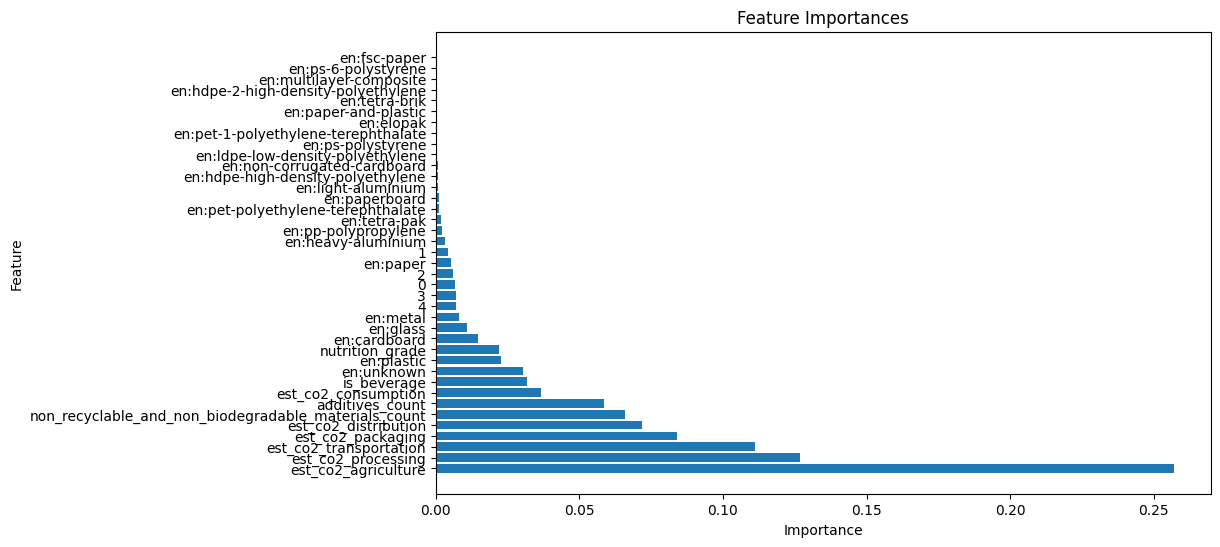

In [ ]:
from sklearn.ensemble import RandomForestClassifier
train_features, test_features, train_targets, test_targets = train_test_split(features1, targets,
                                                    stratify=targets,
                                                    test_size=0.20,random_state=49)
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(train_features, train_targets)

# Make predictions on the test set
test_predicted = classifier.predict(test_features)
res = classification_report(test_targets, test_predicted)
print(res)
importances = classifier.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
feature_importances = pd.DataFrame({'Feature': features1.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
k = 13  # Specify the desired number of top features

# Select the top-k most important features
top_k_features = feature_importances.head(k)['Feature'].tolist()

# Print the top-k features
print(f"Top-{k} Features:")
print(top_k_features)

Top-13 Features:
['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation', 'est_co2_packaging', 'est_co2_distribution', 'non_recyclable_and_non_biodegradable_materials_count', 'additives_count', 'est_co2_consumption', 'is_beverage', 'en:unknown', 'en:plastic', 'nutrition_grade', 'en:cardboard']


In [ ]:
features1_r = features1[top_k_features]
train_features, test_features, train_targets, test_targets = train_test_split(features1_r, targets,
                                                    stratify=targets,
                                                    test_size=0.20,random_state=49)
classifier.fit(train_features, train_targets)

# Make predictions on the test set
test_predicted = classifier.predict(test_features)
res = classification_report(test_targets, test_predicted)
print(res)

<ipython-input-141-f476c4322e06>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(train_features, train_targets)


              precision    recall  f1-score   support

           0       0.86      0.86      0.86       304
           1       0.91      0.91      0.91      1284
           2       0.79      0.73      0.76       714
           3       0.84      0.88      0.86      1218
           4       0.88      0.87      0.87       647

    accuracy                           0.86      4167
   macro avg       0.86      0.85      0.85      4167
weighted avg       0.86      0.86      0.86      4167



In [ ]:
fat = pd.to_numeric(data_train['fat_100g'], errors='coerce').astype(float)
protein = pd.to_numeric(data_train['proteins_100g'], errors='coerce').astype(float)
kcal = pd.to_numeric(data_train['energy_kcal_100g'], errors='coerce').astype(float)
fat = fat.fillna(fat.mean())
protein = protein.fillna(protein.mean())
kcal = kcal.fillna(kcal.mean())

In [ ]:
features1_r['fat_100g'] = fat
features1_r['proteins_100g'] = protein
features1_r['energy_kcal_100g'] = kcal

<ipython-input-178-a7060f49e3f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features1_r['fat_100g'] = fat
<ipython-input-178-a7060f49e3f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features1_r['proteins_100g'] = protein
<ipython-input-178-a7060f49e3f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
features1_r

,est_co2_agriculture,est_co2_processing,est_co2_transportation,est_co2_packaging,est_co2_distribution,non_recyclable_and_non_biodegradable_materials_count,additives_count,est_co2_consumption,is_beverage,en:unknown,en:plastic,nutrition_grade,en:cardboard,fat_100g,proteins_100g,energy_kcal_100g
0,1.405794,0.123400,0.344651,0.400866,0.151978,1.0,1,0.122097,0,0,1,1,0,7.100000,2.200000,270.01574
1,1.772009,5.215055,0.171567,0.288156,0.019531,1.0,10,0.000000,0,0,1,4,1,14.000000,2.900000,366.00000
2,2.239600,0.770511,0.252874,0.281596,0.019531,1.0,3,0.000000,0,0,1,3,0,10.300000,6.200000,423.00000
3,4.536405,0.458632,0.217118,0.185784,0.037393,1.0,2,0.006688,0,0,1,4,0,19.000000,15.000000,270.01574
4,7.918371,0.445327,0.334988,0.478390,0.015709,0.0,0,0.000000,0,1,1,3,0,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0.124785,0.116079,0.145580,0.100104,0.015377,1.0,0,0.000000,1,1,0,3,0,13.947479,7.916524,40.00000
20831,19.495674,6.998544,0.456216,0.100104,0.015709,1.0,0,0.000000,1,1,0,3,0,13.947479,7.916524,270.01574
20832,1.463891,15.259235,0.265547,0.104294,0.017321,1.0,0,0.000000,0,1,0,3,0,45.000000,8.500000,592.00000
20833,7.304731,0.056470,0.233556,0.180553,0.039033,1.0,0,0.006688,0,0,1,4,0,80.000000,0.700000,725.00000


In [252]:
train_features, test_features, train_targets, test_targets = train_test_split(features1_r, targets,
                                                    stratify=targets,
                                                    test_size=0.20,random_state=49)
classifier.fit(train_features, train_targets)

# Make predictions on the test set
test_predicted = classifier.predict(test_features)
res = classification_report(test_targets, test_predicted)
print(res)

<ipython-input-252-22e136234168>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(train_features, train_targets)


              precision    recall  f1-score   support

           0       0.88      0.88      0.88       304
           1       0.92      0.91      0.92      1284
           2       0.79      0.75      0.77       714
           3       0.84      0.88      0.86      1218
           4       0.88      0.87      0.88       647

    accuracy                           0.86      4167
   macro avg       0.86      0.86      0.86      4167
weighted avg       0.86      0.86      0.86      4167



In [ ]:
test_features.replace('unknown', pd.NA, inplace=True)

In [ ]:
features1_r.columns

Index(['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation',
       'est_co2_packaging', 'est_co2_distribution',
       'non_recyclable_and_non_biodegradable_materials_count',
       'additives_count', 'est_co2_consumption', 'is_beverage', 'en:unknown',
       'en:plastic', 'nutrition_grade', 'en:cardboard', 'fat_100g',
       'proteins_100g', 'energy_kcal_100g'],
      dtype='object')

In [ ]:
y_train = df_encoded2[columns]

In [ ]:
y_train.replace('unknown', pd.NA, inplace=True)

In [ ]:
y_train.columns

Index(['non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'en:cardboard', 'en:elopak', 'en:fsc-paper', 'en:glass',
       'en:hdpe-2-high-density-polyethylene',
       'en:hdpe-high-density-polyethylene', 'en:heavy-aluminium',
       'en:ldpe-low-density-polyethylene', 'en:light-aluminium', 'en:metal',
       'en:multilayer-composite', 'en:non-corrugated-cardboard', 'en:paper',
       'en:paper-and-plastic', 'en:paperboard',
       'en:pet-1-polyethylene-terephthalate',
       'en:pet-polyethylene-terephthalate', 'en:plastic',
       'en:pp-polypropylene', 'en:ps-6-polystyrene', 'en:ps-polystyrene',
       'en:tetra-brik', 'en:tetra-pak', 'en:unknown'],
      dtype='object')

In [ ]:
y_train['is_beverage'] = test_features['is_beverage']
y_train['additives_count'] = test_features['additives_count']
y_train['additives_count'].fillna(y_train['additives_count'].mode().iloc[0], inplace=True)

In [222]:
test_features['nutrition_grade'].isna().sum()
test_features['nutrition_grade'].fillna(test_features['nutrition_grade'].mode().iloc[0], inplace=True)

In [223]:
label_encoder = LabelEncoder()

# Apply label encoding to the 'nutrition grade' column
test_features['nutrition_grade'] = label_encoder.fit_transform(test_features['nutrition_grade'])

In [241]:
y_train1['nutrition_grade'] = test_features['nutrition_grade']

In [230]:
y_train = y_train.drop(['nutrition_grade'],axis=1)

In [231]:
encoded_features1 = pd.get_dummies(test_features['nutrition_grade'])
y_train1 = pd.concat([y_train, encoded_features1], axis=1)

In [233]:
y_train1
y_train1.columns = y_train1.columns.astype(str)

In [235]:
fat = pd.to_numeric(test_features['fat_100g'], errors='coerce').astype(float)
protein = pd.to_numeric(test_features['proteins_100g'], errors='coerce').astype(float)
kca = pd.to_numeric(test_features['energy_kcal_100g'], errors='coerce').astype(float)
fat1 = fat.fillna(fat.mean())
protein1 = protein.fillna(protein.mean())
kca1 = kcal.fillna(kcal.mean())
y_train1['fat_100g'] = fat1
y_train1['proteins_100g'] = protein1
y_train1['energy_kcal_100g'] = kcal

In [237]:
columns2 = ['est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation',
       'est_co2_packaging', 'est_co2_distribution',
       'non_recyclable_and_non_biodegradable_materials_count',
       'additives_count', 'est_co2_consumption', 'is_beverage', 'en:unknown',
       'en:plastic', 'nutrition_grade', 'en:cardboard', 'fat_100g',
       'proteins_100g', 'energy_kcal_100g']

In [243]:
y_features = y_train1[columns2]

In [255]:
classifier = RandomForestClassifier(n_estimators=100)
# Train the classifier
classifier.fit(features1_r, targets)

# Make predictions on the test set
test_predicted2 = classifier.predict(y_features)


<ipython-input-255-77010be9b685>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(features1_r, targets)


In [256]:
test_predicted2.shape

(1272,)

In [254]:
predictions = test_predicted
# Convert int64 values to int
predictions = [int(label) for label in predictions]

# Create a dictionary with the desired structure
data = {
    "target": {str(index): label for index, label in enumerate(predictions)}
}

# Convert the dictionary to JSON format
json_data = json.dumps(data, default=int)

# Print the JSON data
print(json_data)

{"target": {"0": 1, "1": 4, "2": 3, "3": 2, "4": 1, "5": 2, "6": 0, "7": 2, "8": 1, "9": 3, "10": 4, "11": 1, "12": 3, "13": 2, "14": 2, "15": 4, "16": 3, "17": 4, "18": 3, "19": 0, "20": 1, "21": 3, "22": 1, "23": 0, "24": 3, "25": 3, "26": 4, "27": 1, "28": 4, "29": 1, "30": 3, "31": 3, "32": 1, "33": 1, "34": 4, "35": 1, "36": 1, "37": 4, "38": 1, "39": 0, "40": 4, "41": 4, "42": 2, "43": 4, "44": 3, "45": 4, "46": 4, "47": 4, "48": 2, "49": 4, "50": 1, "51": 3, "52": 3, "53": 1, "54": 1, "55": 3, "56": 2, "57": 0, "58": 4, "59": 3, "60": 1, "61": 2, "62": 2, "63": 1, "64": 2, "65": 2, "66": 3, "67": 4, "68": 2, "69": 2, "70": 3, "71": 2, "72": 0, "73": 4, "74": 3, "75": 3, "76": 2, "77": 3, "78": 2, "79": 0, "80": 2, "81": 4, "82": 1, "83": 3, "84": 1, "85": 1, "86": 3, "87": 3, "88": 2, "89": 3, "90": 4, "91": 2, "92": 0, "93": 3, "94": 1, "95": 1, "96": 3, "97": 3, "98": 3, "99": 2, "100": 2, "101": 0, "102": 2, "103": 3, "104": 3, "105": 1, "106": 1, "107": 3, "108": 3, "109": 2

In [ ]:
file_path = '/content/predictions.json'

# Save the JSON data to the file
with open(file_path, 'w') as file:
    file.write(json_data)

In [ ]:
for column in y_train.columns:
  y_train[column] = y_train[column].astype(float)

<ipython-input-27-c4bf1a6c235a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[column] = y_train[column].astype(float)


In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272 entries, 0 to 1271
Data columns (total 31 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   non_recyclable_and_non_biodegradable_materials_count  1272 non-null   float64
 1   est_co2_agriculture                                   1272 non-null   float64
 2   est_co2_consumption                                   1272 non-null   float64
 3   est_co2_distribution                                  1272 non-null   float64
 4   est_co2_packaging                                     1272 non-null   float64
 5   est_co2_processing                                    1272 non-null   float64
 6   est_co2_transportation                                1272 non-null   float64
 7   en:cardboard                                          1272 non-null   float64
 8   en:elopak                                             1272

In [ ]:
model = xgb.XGBClassifier()
model.fit(features, targets)
test_predicted = model.predict(y_train)
predictions = test_predicted
# Convert int64 values to int
predictions = [int(label) for label in predictions]

# Create a dictionary with the desired structure
data = {
    "target": {str(index): label for index, label in enumerate(predictions)}
}

# Convert the dictionary to JSON format
json_data = json.dumps(data, default=int)

file_path = '/content/predictionsxgboost.json'

# Save the JSON data to the file
with open(file_path, 'w') as file:
    file.write(json_data)

In [259]:
predictions = test_predicted2
# Convert int64 values to int
predictions = [int(label) for label in predictions]

# Create a dictionary with the desired structure
data = {
    "target": {str(index): label for index, label in enumerate(predictions)}
}

# Convert the dictionary to JSON format
json_data = json.dumps(data, default=int)

file_path = '/content/predictionsupdated1.json'

# Save the JSON data to the file
with open(file_path, 'w') as file:
    file.write(json_data)